In [1]:
# import libs
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


# Data

**Fundamental Energy Data (Provided)**

*Recent and Historic Energy Statistics*

- Energy Data - Consumption.csv

- Energy Data - Imports & Exports.csv

- Energy Data - Production.csv

- Energy Data - Stocks.csv

<br>

**Market Data**

*Futures Curves (From Refinitiv)*

- wti_futures_curve_clean.csv

- hh_nat_gas_futures_curve.csv

*Futures Trading Volume (From Refinitiv)*

- wti_futures_continuous_volume.csv

- hh_nat_gas_futures_volume_.csv

*1 Month Implied Volatility (From Refinitiv)*

- wti_continuous_options_deltas.csv
    
- wti_continuous_options_moneyness.csv

- hh_nat_gas_continuous_options_deltas.csv

- hh_nat_gas_continuous_options_moneyness.csv

*Energy Sector Stocks and Commodities (HLOC) (Provided)*

- all_commodities.csv

- all_stocks_and_etfs.csv

- stock_descriptions.csv


## Fundamental Energy Data

In [48]:
# Define paths

fundamental_data_folderpath = r"data\!Spring_Invitational_2024_data\Datathon_Data" 

consumption = pd.read_csv(os.path.join(fundamental_data_folderpath, 'Energy Data - Consumption.csv'))

imports_exports = pd.read_csv(os.path.join(fundamental_data_folderpath, 'Energy Data - Imports & Exports.csv'))

production = pd.read_csv(os.path.join(fundamental_data_folderpath, 'Energy Data - Production.csv'))

stocks = pd.read_csv(os.path.join(fundamental_data_folderpath, 'Energy Data - Stocks.csv'))


### EDA on Fundamental Energy Data

**Note:**

For consumption data, we are using the series 'Natural Gas Consumption, Total' to represent natural gas consumption, and a weighted average of 

['Total Petroleum Consumed by the Residential Sector',
       'Total Petroleum Consumed by the Commercial Sector',
       'Total Hydrocarbon Gas Liquids Consumed by the Industrial Sector',
       'Total Petroleum Consumed by the Industrial Sector',
       'Total Petroleum Consumed by the Transportation Sector',
       'Total Petroleum Consumed by the Electric Power Sector']

to represent total petroleum consumption.

In [49]:
consumption.head()

,EIA_ID,YYYYMM,Date,Value,Column_Order,Description,Unit,Energy Type,Energy Category,Energy Class,Sector
0,DFRCPUS,197301,1/1/1973,1706.943,1,Distillate Fuel Oil Consumed by the Residentia...,Thousand Barrels per Day,Distillate Fuel Oil,Distillate Fuel Oil,Petroleum,Residential
1,DFRCPUS,197302,2/1/1973,1614.436,1,Distillate Fuel Oil Consumed by the Residentia...,Thousand Barrels per Day,Distillate Fuel Oil,Distillate Fuel Oil,Petroleum,Residential
2,DFRCPUS,197303,3/1/1973,1140.521,1,Distillate Fuel Oil Consumed by the Residentia...,Thousand Barrels per Day,Distillate Fuel Oil,Distillate Fuel Oil,Petroleum,Residential
3,DFRCPUS,197304,4/1/1973,824.604,1,Distillate Fuel Oil Consumed by the Residentia...,Thousand Barrels per Day,Distillate Fuel Oil,Distillate Fuel Oil,Petroleum,Residential
4,DFRCPUS,197305,5/1/1973,676.745,1,Distillate Fuel Oil Consumed by the Residentia...,Thousand Barrels per Day,Distillate Fuel Oil,Distillate Fuel Oil,Petroleum,Residential


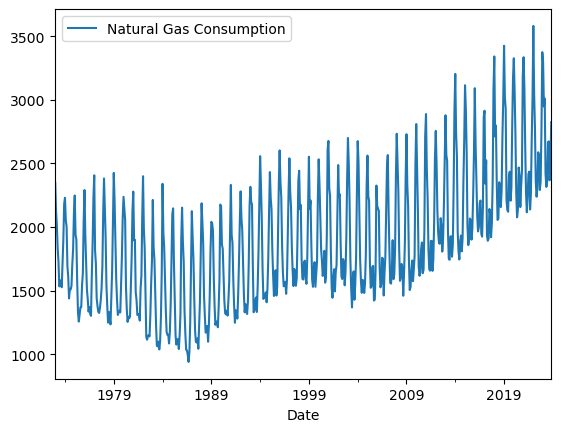

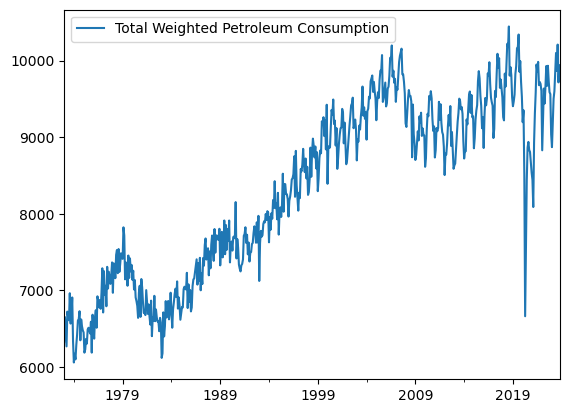

In [108]:
# # EDA for consumption data

# print(consumption['Description'].unique())
# print(consumption['Energy Category'].unique())
# print(consumption['Energy Class'].unique())

# Convert 'Date' to datetime
consumption['Date'] = pd.to_datetime(consumption['Date'])

# Create a dict of dicts of dfs for the Petroleum and Natural Gas Categories
consumption_dict = {}
petroleum_df = consumption[consumption['Energy Class'] == 'Petroleum']
natural_gas_df = consumption[consumption['Energy Class'] == 'Natural Gas']

#Print all 'Description' values in both dfs where the word 'Total' is present
petroleum_df[petroleum_df['Description'].str.contains('Total')]['Description'].unique()

natural_gas_df[natural_gas_df['Description'].str.contains('Total')]['Description'].unique()

# To keep: 
petroleum_series_to_keep = ['Total Petroleum Consumed by the Residential Sector',
       'Total Petroleum Consumed by the Commercial Sector',
       'Total Hydrocarbon Gas Liquids Consumed by the Industrial Sector',
       'Total Petroleum Consumed by the Industrial Sector',
       'Total Petroleum Consumed by the Transportation Sector',
       'Total Petroleum Consumed by the Electric Power Sector']

natural_gas_series_to_keep = ['Natural Gas Consumption, Total']

# Subset petroleum and natural gas dfs to only keep the series we want
petroleum_df = petroleum_df[petroleum_df['Description'].isin(petroleum_series_to_keep)]
natural_gas_df = natural_gas_df[natural_gas_df['Description'].isin(natural_gas_series_to_keep)]


# Convert the 'Value' column to float for both petroleum_df and natural_gas_df
petroleum_df['Value'] = pd.to_numeric(petroleum_df['Value'].str.replace(',', ''), errors='coerce')
natural_gas_df['Value'] = pd.to_numeric(natural_gas_df['Value'].str.replace(',', ''), errors='coerce')

# # Use groupby to find the weight of each EIA_ID in the petroleum and natural gas classes by taking the sum of the 'Value' column and dividing by the sum of the 'Value' column for all EIA_IDs in the class
# petroleum_df.groupby('EIA_ID').sum()['Value'] 
grouped_values = petroleum_df.groupby('EIA_ID')['Value'].sum() # This is ok because all units are the same
total_value = grouped_values.sum()

petroleum_weights = grouped_values / total_value

petro_dict = {}

# Extract the individual series identified by their EIA_IDs from petroleum_df 
for eia_id in petroleum_df['EIA_ID'].unique():
    petro_dict[eia_id] = petroleum_df[petroleum_df['EIA_ID'] == eia_id]


# Validate the dict structure and endpoint dfs
petro_dict[list(petro_dict.keys())[5]]




# # # Use petroleum weights to create a new df with the weighted values over time
petroleum_weighted_df = pd.DataFrame()
petroleum_weighted_df.index = petroleum_df['Date'].unique()
for eia_id in petro_dict.keys():
    petroleum_weighted_df[eia_id] = petro_dict[eia_id].groupby('Date')['Value'].sum() * petroleum_weights[eia_id]

petroleum_weighted_df['Total Weighted Petroleum Consumption'] = petroleum_weighted_df.sum(axis=1)
petroleum_weighted_df

natural_gas_df

# # Define petroleum_weighted_consumption as a series equal to the 'Total Weighted Petroleum Consumption' column of petroleum_weighted_df
petroleum_weighted_consumption = petroleum_weighted_df['Total Weighted Petroleum Consumption']
# # Define natural_gas_consumption as a series equal to the 'Value' column of natural_gas_df
natural_gas_consumption = natural_gas_df['Value']
natural_gas_consumption.index = natural_gas_df['Date']

# Remove the first 24 rows of natural_gas_consumption, which report annualized rather than monthly values
natural_gas_consumption = natural_gas_consumption[24:]

# Each year reports 12 monthly values and an annual value. Therefore, for any duplicate indices left in the series, drop the row with the annual value by seleting the 2nd duplicate
natural_gas_consumption = natural_gas_consumption[~natural_gas_consumption.index.duplicated(keep='last')]


#Examine both series
petroleum_weighted_consumption.describe()
natural_gas_consumption.describe()

# Rename the values in the natural_gas_consumption series to 'Natural Gas Consumption'
natural_gas_consumption.name = 'Natural Gas Consumption'

natural_gas_consumption.plot()
plt.legend()
plt.show()
petroleum_weighted_consumption.plot()
plt.legend()
plt.show()


### De-Trending and De-Seasonalizing Consumption

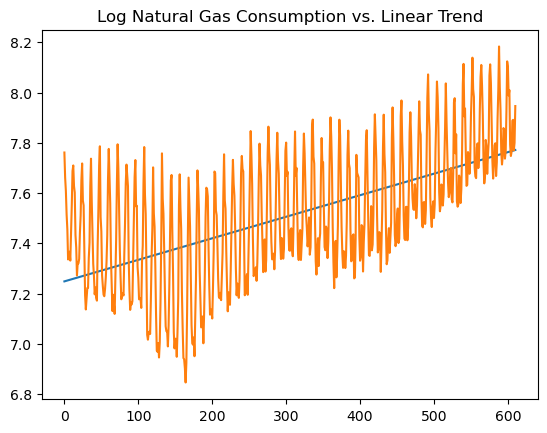

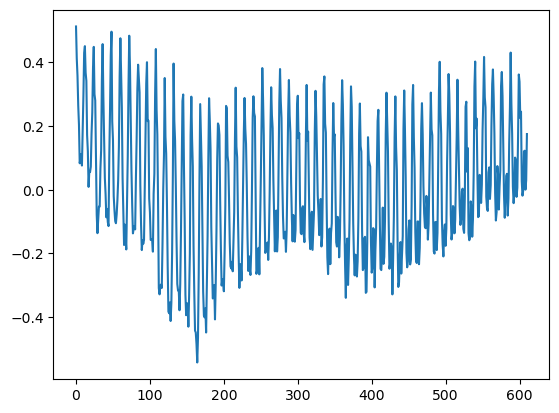

In [144]:
# De-Trend / De-Seasonalize Oil and Natural Gas Consumption

import statsmodels.api as sm
from statsmodels.api import tsa
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error



# Decompose the natural gas time series


# Take log and find best linear model
log_ng_consumption = np.log(natural_gas_consumption)

# Fit best linear model via OLS
ols_model = sm.OLS(log_ng_consumption, sm.add_constant(np.arange(len(log_ng_consumption)))).fit()

# Plot the log of the natural gas consumption against linear trend
plt.plot(np.arange(len(log_ng_consumption)), ols_model.predict(sm.add_constant(np.arange(len(log_ng_consumption)))))
plt.plot(np.arange(len(log_ng_consumption)), log_ng_consumption)
plt.title('Log Natural Gas Consumption vs. Linear Trend')
plt.show()

# Subtract the linear trend from the log of the natural gas consumption
log_ng_detrended = log_ng_consumption - ols_model.predict(sm.add_constant(np.arange(len(log_ng_consumption))))

# Plot the de-trended log of the natural gas consumption
plt.plot(np.arange(len(log_ng_detrended)), log_ng_detrended)


ng_decomposition = seasonal_decompose(natural_gas_consumption, model='additive', period=12)

# Extract seasonal component
ng_seasonal = ng_decomposition.seasonal

# De-seasonalize log_ng_detrended with 





# # De-trended series
# ng_detrended = natural_gas_consumption - ng_trend

# # De-seasonalized series
# deseasonalized = ng_detrended - ng_seasonal

# # Optionally, you can create a de-trended and de-seasonalized series
# ng_consumption_deseasonalized_detrended = ng_residual

# plot_list = [natural_gas_consumption, ng_trend, ng_seasonal, ng_residual, ng_detrended, ng_consumption_deseasonalized_detrended]

# for series in plot_list:
#     series.plot()
#     plt.legend()
#     plt.show()

# #plot the log of the natural gas consumption
# np.log(natural_gas_consumption).plot()


12277997.514

In [59]:
# # petroleum_df: convert 'Value' to float, coercing errors to NaN
# petroleum_df['Value'] = petroleum_df['Value'].str.replace(',', '')
# petroleum_df['Value'] = pd.to_numeric(petroleum_df['Value'], errors='coerce')

# # Print all 'Descriptions' in petroleum_df for which 'Value' is NaN
# petroleum_df[petroleum_df['Value'].isna()]['Description'].unique()

# # Drop all rows in petroleum_df for which 'Value' is NaN
# petroleum_df = petroleum_df.dropna(subset=['Value'])

# # natural_gas_df: convert 'Value' to float, coercing errors to NaN
# natural_gas_df['Value'] = natural_gas_df['Value'].str.replace(',', '')
# natural_gas_df['Value'] = pd.to_numeric(natural_gas_df['Value'], errors='coerce')

# # Print all 'Descriptions' in natural_gas_df for which 'Value' is NaN
# natural_gas_df[natural_gas_df['Value'].isna()]['Description'].unique()




array(['Natural Gas Consumed by the Other Industrial Sector, Total',
       'Natural Gas Consumed by the Industrial Sector, Total',
       'Natural Gas Consumed by the Transportation Sector, Total',
       'Natural Gas Consumption, Total'], dtype=object)

In [54]:
consumption[consumption['Description'] == 'Natural Gas Consumed by the Transportation Sector, Total']

,EIA_ID,YYYYMM,Date,Value,Column_Order,Description,Unit,Energy Type,Energy Category,Energy Class,Sector
48324,NGACPUS,194913,1950-01-01,Not Available,10,Natural Gas Consumed by the Transportation Sec...,Billion Cubic Feet,Total,Natural Gas,Natural Gas,Transportation
48325,NGACPUS,195013,1951-01-01,125.546,10,Natural Gas Consumed by the Transportation Sec...,Billion Cubic Feet,Total,Natural Gas,Natural Gas,Transportation
48326,NGACPUS,195113,1952-01-01,192.496,10,Natural Gas Consumed by the Transportation Sec...,Billion Cubic Feet,Total,Natural Gas,Natural Gas,Transportation
48327,NGACPUS,195213,1953-01-01,207.207,10,Natural Gas Consumed by the Transportation Sec...,Billion Cubic Feet,Total,Natural Gas,Natural Gas,Transportation
48328,NGACPUS,195313,1954-01-01,230.314,10,Natural Gas Consumed by the Transportation Sec...,Billion Cubic Feet,Total,Natural Gas,Natural Gas,Transportation
...,...,...,...,...,...,...,...,...,...,...,...
49004,NGACPUS,202307,2023-07-01,104.597,10,Natural Gas Consumed by the Transportation Sec...,Billion Cubic Feet,Total,Natural Gas,Natural Gas,Transportation
49005,NGACPUS,202308,2023-08-01,104.914,10,Natural Gas Consumed by the Transportation Sec...,Billion Cubic Feet,Total,Natural Gas,Natural Gas,Transportation
49006,NGACPUS,202309,2023-09-01,93.285,10,Natural Gas Consumed by the Transportation Sec...,Billion Cubic Feet,Total,Natural Gas,Natural Gas,Transportation
49007,NGACPUS,202310,2023-10-01,96.16,10,Natural Gas Consumed by the Transportation Sec...,Billion Cubic Feet,Total,Natural Gas,Natural Gas,Transportation


## Market Data

In [3]:
# Define paths

futures_data_path = 'data\!new_datasets\refinitiv_futures_data'

market_data_folderpath = r"data\!Spring_Invitational_2024_data\Datathon_Data"


### Futures Curves

In [ ]:

wti_futures_curve = pd.read_csv(os.path.join(futures_data_path, 'wti_futures_curve_clean.csv'))

hh_nat_gas_futures_curve = pd.read_csv(os.path.join(futures_data_path, 'hh_nat_gas_futures_curve.csv'))



### Futures Options and Volume

In [ ]:
wti_options_deltas = pd.read_csv(os.path.join(futures_data_path, 'wti_continuous_options_deltas.csv'))

wti_options_moneyness = pd.read_csv(os.path.join(futures_data_path, 'wti_continuous_options_moneyness.csv'))

hh_nat_gas_options_deltas = pd.read_csv(os.path.join(futures_data_path, 'hh_nat_gas_continuous_options_deltas.csv'))

hh_nat_gas_options_moneyness = pd.read_csv(os.path.join(futures_data_path, 'hh_nat_gas_continuous_options_moneyness.csv'))

wti_futures_volume = pd.read_csv(os.path.join(futures_data_path, 'wti_futures_continuous_volume.csv'))

hh_nat_gas_futures_volume = pd.read_csv(os.path.join(futures_data_path, 'hh_nat_gas_futures_volume_.csv'))

### Commodity Prices and Stock Market

In [ ]:
all_commodities = pd.read_csv(os.path.join(market_data_folderpath, 'all_commodities.csv'))

all_stocks = pd.read_csv(os.path.join(market_data_folderpath, 'all_stocks_and_etfs.csv'))

stock_descriptions = pd.read_csv(os.path.join(market_data_folderpath, 'stock_descriptions.csv'))

# SVAR Model

** Model Specification **

$$
A_0 Y_t = A_1 Y_{t-1} + ... + A_p Y_{t-p} + B \varepsilon_t
$$

Where:
- $Y_t$: Vector of endogenous variables at time $t$.
- $A_0, A_1, ..., A_p$: Matrices of coefficients capturing the contemporaneous and lagged relationships among the variables.
- $\varepsilon_t$: Vector of structural shocks.
- $B$: Matrix mapping structural shocks to the endogenous variables, incorporating theoretical restrictions.

** Estimation Procedure **

1. **Estimate Reduced-Form VAR**: Fit a Vector Autoregression model to the data without structural restrictions to obtain reduced-form coefficients and residuals.

2. **Impose Structural Restrictions**: Based on economic theory, apply restrictions to the matrices $A_0$ and $B$ to identify the structural shocks.

3. **Recover Structural Shocks**: Utilize the estimated VAR coefficients and imposed restrictions to derive the structural shocks ($\varepsilon_t$) and matrices $A_0$ and $B$.

4. **IRFs and Variance Decomposition**: Examine impulse response functions and forecast error variance decompositions to assess the effects of structural shocks.


In [ ]:
# 